In [122]:

import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
import pandas as pd



In [123]:
# dimensionxy=50
# x = np.linspace(0, 50, 50)
# y = np.linspace(0, 50, 50)
# XX, YY = np.meshgrid(x, y)


# model = gs.Gaussian(dim=2, var=1,len_scale=6)
dimensionxy=25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)




In [124]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0)

def process_single_point(B_discretized, row_index, col_index):
    # 构建转移概率矩阵
    transition_matrix = np.zeros((n_states, n_states))

    for month in range(24):  # 24次状态转移
        current_state = int(B_discretized[month, col_index])
        next_state = int(B_discretized[month + 1, col_index])
        transition_matrix[current_state, next_state] += 1

    # 归一化转移概率矩阵
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # 使用马尔可夫链预测指定位置的下一个状态
    last_state = int(B_discretized[row_index, col_index])
    predicted_state = np.random.choice(np.arange(n_states), p=transition_matrix[last_state])

    # 将预测的状态扩展到整个特征维度
    dummy_states = np.full((1, B_discretized.shape[1]), fill_value=-1)
    dummy_states[0, col_index] = predicted_state

    # 将预测的状态转换回实际值范围
    predicted_values = est.inverse_transform(dummy_states)
    predicted_value = predicted_values[0, col_index]

    print(f"Predicted value for position ({row_index}, {col_index}): {predicted_value}")
    return predicted_value

def calcuCirculation_for_point(row_index, col_index, time):
    all_processed_values = []
    results_df = pd.DataFrame()

    if time == 2:
        for i in range(1, time):
            processed_value = process_single_point(B_discretized, row_index, col_index)
            all_processed_values.append(pd.Series([processed_value], name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    else:
        for i in range(1, time):
            processed_value = process_single_point(B_discretized, row_index, col_index)
            all_processed_values.append(pd.Series([processed_value], name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

# 调用函数预测特定点的下一个状态，假设你要预测第25行第10列的位置
row_index = 24  # 第25行
col_index = 9   # 第10列

times = 1001
calcuCirculation_for_point(row_index, col_index, 2)
calcuCirculation_for_point(row_index, col_index, times)

Predicted value for position (24, 9): 0.3205100715481153
Predicted value for position (24, 9): 0.3205100715481153
Predicted value for position (24, 9): -0.8842550909756126
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.8842550909756126
Predicted value for position (24, 9): -0.8842550909756126
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.8842550909756126
Predicted value for position (24, 9): 0.3205100715481153
Predicted value for position (24, 9): -0.8842550909756126
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.28187250971374866
Predicted value for position (24, 9): -0.8842550909756126
Predicted

In [125]:

df = pd.read_csv("./repro-out/pred_nonoisy.csv")

df2=pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

# out0 = df["Out0"]=df2["Out0"]
out0 =df2["Out0"]
# df["value0"]=df2["value0"]
x= df.index
data = df.copy()
            

MAE


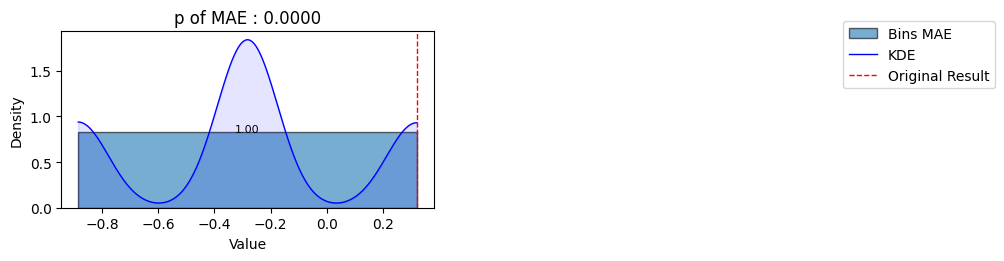

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, iqr
from astropy.stats import knuth_bin_width, bayesian_blocks

# 定义不同组距计算方法
def calculate_bin_count(data, method='fd'):
    N = len(data)
    if method == 'sqrt':
        return int(np.sqrt(N))
    elif method == 'sturges':
        return int(np.log2(N) + 1)
    elif method == 'fd':
        bin_width = 2 * iqr(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    elif method == 'scott':
        bin_width = 3.5 * np.std(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    else:
        raise ValueError("Invalid method")

# 定义自适应组距计算方法
def calculate_adaptive_bins(data, method='knuth'):
    if method == 'knuth':
        bin_width = knuth_bin_width(data)
        bins = int((data.max() - data.min()) / bin_width)
    elif method == 'bayesian_blocks':
        bins = bayesian_blocks(data)
    else:
        raise ValueError("Invalid method")
    return bins

# 绘制直方图
def plot_histogram(ax, data, bins, color, label):
    counts, bin_edges, _ = ax.hist(data, bins=bins, density=True, alpha=0.6, edgecolor='black', color=color, label=label)
    return counts, bin_edges

# 绘制KDE曲线
def plot_kde(ax, data):
    kde = gaussian_kde(data)
    kde_x = np.linspace(data.min(), data.max(), 1000)
    kde_y = kde(kde_x)
    ax.plot(kde_x, kde_y, 'blue', linewidth=1, label='KDE')
    ax.fill_between(kde_x, kde_y, where=((kde_x >= data.min()) & (kde_x <= data.max())), color='blue', alpha=0.1)
    return kde_x, kde_y

# 标注直方图
def annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0):
    reproducibility = 0
    for j in range(len(counts)):
        if bin_edges[j] <= out0.loc[row_index].item() < bin_edges[j+1]:
            reproducibility = bin_probs[j]
            print(bin_probs[j])
            break
        ax.text(bin_edges[j] + (bin_edges[j+1] - bin_edges[j]) / 2, counts[j], f'{bin_probs[j]:.2f}', fontsize=8, ha='center')
    return reproducibility

# 绘制对比图
def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
    bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    # bins = calculate_adaptive_bins(row_data, method="knuth")

    # bins = calculate_bin_count(row_data, method="scott")




    counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
    
    bin_widths = np.diff(bin_edges)
    bin_probs = counts * bin_widths
    plot_kde(ax, row_data)
    
    ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
    reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'p of {row_name} : {reproducibility:.4f}')
    return reproducibility

# 初始化子图
# def initialize_subplots(data, plotrowcount):
#     num_rows = (data.shape[0] + plotrowcount - 1) // plotrowcount
#     fig, axs = plt.subplots(num_rows, plotrowcount, figsize=(plotrowcount * 5, num_rows * 3.2))
#     if num_rows == 1:
#         axs = axs[np.newaxis, :]  # 保证 axs 是二维数组
#     return fig, axs, num_rows


# 初始化子图
def initialize_subplots(data, plotrowcount):
    num_rows = (data.shape[0] + plotrowcount - 1) // plotrowcount
    fig, axs = plt.subplots(num_rows, plotrowcount, figsize=(plotrowcount * 5, num_rows * 3.2))
    axs = axs.flatten()  # 确保 axs 是一维数组，便于索引
    return fig, axs, num_rows



# 隐藏多余的子图
def hide_extra_subplots(axs, data, num_rows, plotrowcount):
    for i in range(len(data), num_rows * plotrowcount):
        fig.delaxes(axs.flat[i])

# 创建图例
def create_legend(axs):
    handles, labels = [], []
    for ax in axs.flat:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
    return handles, labels

rowName= ["MAE", "MAPE", "RMSE", "R2", "Adj.R2", "AIC"]
total_probability_sum = 0
plotrowcount = 2
colors = plt.get_cmap('tab10')

fig, axs, num_rows = initialize_subplots(data, plotrowcount)

# for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
#     print(name)
#     ax = axs[index // plotrowcount, index % plotrowcount] if num_rows > 1 else axs[index % plotrowcount]
#     # ax = axs[index]
#     total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)

# 在初始化子图时，已经展平了axs数组，所以在绘制时只需要用一维索引
for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
    print(name)
    ax = axs[index]  # 一维索引即可
    total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)


hide_extra_subplots(axs, data, num_rows, plotrowcount)

handles, labels = create_legend(axs)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.66))

plt.subplots_adjust(hspace=0.1, wspace=0.1)
average_probability = total_probability_sum / data.shape[0]
# plt.suptitle(f'The summary of reproducbility p: {average_probability*100:.4f}%', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.85])
plt.show()

In [127]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde, iqr
# from astropy.stats import knuth_bin_width, bayesian_blocks

# # 定义不同组距计算方法
# def calculate_bin_count(data, method='fd'):
#     N = len(data)
#     if method == 'sqrt':
#         return int(np.sqrt(N))
#     elif method == 'sturges':
#         return int(np.log2(N) + 1)
#     elif method == 'fd':
#         bin_width = 2 * iqr(data) / np.cbrt(N)
#         return max(1, int((data.max() - data.min()) / bin_width))
#     elif method == 'scott':
#         bin_width = 3.5 * np.std(data) / np.cbrt(N)
#         return max(1, int((data.max() - data.min()) / bin_width))
#     else:
#         raise ValueError("Invalid method")

# # 定义自适应组距计算方法
# def calculate_adaptive_bins(data, method='knuth'):
#     if method == 'knuth':
#         bin_width = knuth_bin_width(data)
#         bins = int((data.max() - data.min()) / bin_width)
#     elif method == 'bayesian_blocks':
#         bins = bayesian_blocks(data)
#     else:
#         raise ValueError("Invalid method")
#     return bins

# # 绘制直方图
# def plot_histogram(ax, data, bins, color, label):
#     counts, bin_edges, _ = ax.hist(data, bins=bins, density=True, alpha=0.6, edgecolor='black', color=color, label=label)
#     return counts, bin_edges

# # 绘制KDE曲线
# def plot_kde(ax, data):
#     kde = gaussian_kde(data)
#     kde_x = np.linspace(data.min(), data.max(), 1000)
#     kde_y = kde(kde_x)
#     ax.plot(kde_x, kde_y, 'blue', linewidth=1, label='KDE')
#     ax.fill_between(kde_x, kde_y, where=((kde_x >= data.min()) & (kde_x <= data.max())), color='blue', alpha=0.1)
#     return kde_x, kde_y

# # 标注直方图
# def annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0):
#     reproducibility = 0
#     for j in range(len(counts)):
#         if bin_edges[j] <= out0.loc[row_index].item() < bin_edges[j+1]:
#             reproducibility = bin_probs[j]
#             print(bin_probs[j])
#             break
#         ax.text(bin_edges[j] + (bin_edges[j+1] - bin_edges[j]) / 2, counts[j], f'{bin_probs[j]:.2f}', fontsize=8, ha='center')
#     return reproducibility

# # 绘制对比图
# # def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
# #     bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    
# #     counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
    
# #     bin_widths = np.diff(bin_edges)
# #     bin_probs = counts * bin_widths
# #     plot_kde(ax, row_data)
    
# #     ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
# #     reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
# #     ax.set_xlabel('Value')
# #     ax.set_ylabel('Density')
# #     ax.set_title(f'p of {row_name} : {reproducibility:.4f}')
# #     return reproducibility
# # def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
# #     print(f"Plotting {row_name} for row {row_index}")
# #     bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
# #     print(f"Bins: {bins}")
# #     counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
# #     print(f"Counts: {counts}, Bin edges: {bin_edges}")
    
# #     bin_widths = np.diff(bin_edges)
# #     bin_probs = counts * bin_widths
# #     plot_kde(ax, row_data)
    
# #     ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
# #     reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
# #     ax.set_xlabel('Value')
# #     ax.set_ylabel('Density')
# #     ax.set_title(f'p of {row_name} : {reproducibility:.4f}')
# #     return reproducibility

# def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
#     print(f"Plotting {row_name} for row {row_index}")
    
#     # If row_data is already a scalar, handle it accordingly
#     if isinstance(row_data, np.ndarray):
#         row_data = row_data.flatten()
#     elif isinstance(row_data, (pd.Series, pd.DataFrame)):
#         row_data = row_data.values.flatten()
#     else:
#         row_data = np.array([row_data])

#     bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
#     print(f"Bins: {bins}")
    
#     counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
#     print(f"Counts: {counts}, Bin edges: {bin_edges}")
    
#     bin_widths = np.diff(bin_edges)
#     bin_probs = counts * bin_widths
#     plot_kde(ax, row_data)
    
#     ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
#     reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
#     ax.set_xlabel('Value')
#     ax.set_ylabel('Density')
#     ax.set_title(f'p of {row_name} : {reproducibility:.4f}')
#     return reproducibility
# # 初始化子图
# def initialize_subplots(data, plotrowcount):
#     num_rows = (data.shape[0] + plotrowcount - 1) // plotrowcount
#     fig, axs = plt.subplots(num_rows, plotrowcount, figsize=(plotrowcount * 5, num_rows * 3.2))
#     axs = axs.flatten()  # 确保 axs 是一维数组，便于索引
#     return fig, axs, num_rows

# # 隐藏多余的子图
# def hide_extra_subplots(axs, data, num_rows, plotrowcount):
#     for i in range(len(data), num_rows * plotrowcount):
#         fig.delaxes(axs[i])

# # 创建图例
# def create_legend(axs):
#     handles, labels = [], []
#     for ax in axs:
#         for handle, label in zip(*ax.get_legend_handles_labels()):
#             if label not in labels:
#                 handles.append(handle)
#                 labels.append(label)
#     return handles, labels

# rowName= ["MAE"]
# total_probability_sum = 0
# plotrowcount = 2
# colors = plt.get_cmap('tab10')

# fig, axs, num_rows = initialize_subplots(data, plotrowcount)

# # for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
# #     ax = axs[index]
# #     total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)

# # for index, row in data.iterrows():
# #     for name in rowName:

# for index, row in data.iterrows():
#     for name in rowName:
#         ax = axs[index]
#         total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)


# for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
#     print(f"Index: {index}, Name: {name}")
#     # print(f"Row data: {row[1].values}")  # 打印当前行的数据
#     ax = axs[index]
#     total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)

# hide_extra_subplots(axs, data, num_rows, plotrowcount)

# handles, labels = create_legend(axs)
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.66))

# plt.subplots_adjust(hspace=0.1, wspace=0.1)
# average_probability = total_probability_sum / data.shape[0]
# # plt.suptitle(f'The summary of reproducbility p: {average_probability*100:.4f}%', fontsize=14)
# plt.tight_layout(rect=[0, 0, 0.85, 0.85])
# plt.show()

Out1       0.320510
Out2      -0.884255
Out3      -0.281873
Out4      -0.281873
Out5      -0.281873
             ...   
Out996    -0.281873
Out997    -0.281873
Out998    -0.281873
Out999     0.320510
Out1000   -0.281873
Name: 0, Length: 1000, dtype: float64


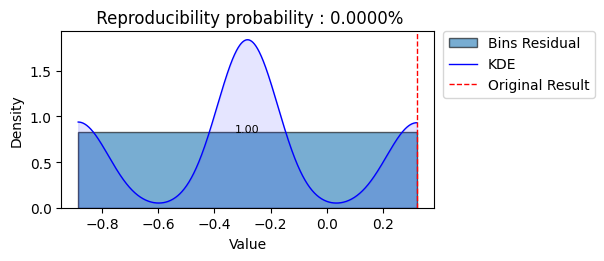

In [128]:


# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, iqr
from astropy.stats import knuth_bin_width, bayesian_blocks

# 定义不同组距计算方法
def calculate_bin_count(data, method='fd'):
    N = len(data)
    if method == 'sqrt':
        return int(np.sqrt(N))
    elif method == 'sturges':
        return int(np.log2(N) + 1)
    elif method == 'fd':
        bin_width = 2 * iqr(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    elif method == 'scott':
        bin_width = 3.5 * np.std(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    else:
        raise ValueError("Invalid method")

# 定义自适应组距计算方法
def calculate_adaptive_bins(data, method='knuth'):
    if method == 'knuth':
        bin_width = knuth_bin_width(data)
        bins = int((data.max() - data.min()) / bin_width)
    elif method == 'bayesian_blocks':
        bins = bayesian_blocks(data)
    else:
        raise ValueError("Invalid method")
    return bins

# 绘制直方图
def plot_histogram(ax, data, bins, color, label):
    counts, bin_edges, _ = ax.hist(data, bins=bins, density=True, alpha=0.6, edgecolor='black', color=color, label=label)
    return counts, bin_edges

# 绘制KDE曲线
def plot_kde(ax, data):
    kde = gaussian_kde(data)
    kde_x = np.linspace(data.min(), data.max(), 1000)
    kde_y = kde(kde_x)
    ax.plot(kde_x, kde_y, 'blue', linewidth=1, label='KDE')
    ax.fill_between(kde_x, kde_y, where=((kde_x >= data.min()) & (kde_x <= data.max())), color='blue', alpha=0.1)
    return kde_x, kde_y

# 标注直方图
def annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0):
    reproducibility = 0
    for j in range(len(counts)):
        if bin_edges[j] <= out0.loc[row_index].item() < bin_edges[j+1]:
            reproducibility = bin_probs[j]
            print(bin_probs[j])
            break
        ax.text(bin_edges[j] + (bin_edges[j+1] - bin_edges[j]) / 2, counts[j], f'{bin_probs[j]:.2f}', fontsize=8, ha='center')
    return reproducibility

# 绘制对比图
def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
    # bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
    
    bin_widths = np.diff(bin_edges)
    bin_probs = counts * bin_widths
    plot_kde(ax, row_data)
    
    ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
    reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f' Reproducibility probability : {reproducibility*100:.4f}%')
    return reproducibility

# 初始化子图
def initialize_subplots(data, plotrowcount):
    num_rows = (data.shape[0] + plotrowcount - 1) // plotrowcount
    fig, axs = plt.subplots(num_rows, plotrowcount, figsize=(plotrowcount * 5, num_rows * 3.2))
    return fig, axs, num_rows

# 隐藏多余的子图
def hide_extra_subplots(axs, data, num_rows, plotrowcount):
    for i in range(len(data), num_rows * plotrowcount):
        fig.delaxes(axs.flat[i])

# 创建图例
def create_legend(axs):
    handles, labels = [], []
    for ax in axs.flat:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
    return handles, labels



# rowName= ["MAE", "MAPE", "RMSE", "R2", "Adj.R2", "AIC"]
rowName= [ "Residual"]
total_probability_sum = 0
plotrowcount = 2
colors = plt.get_cmap('tab10')

from itertools import zip_longest
fig, axs, num_rows = initialize_subplots(data, plotrowcount)

for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
    print(row[1])
    # ax = axs[index // plotrowcount, index % plotrowcount]
    ax = axs[index]
    total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)

hide_extra_subplots(axs, data, num_rows, plotrowcount)

handles, labels = create_legend(axs)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.45, 0.63))

plt.subplots_adjust(hspace=0.1, wspace=0.1)
average_probability = total_probability_sum / data.shape[0]
# plt.suptitle(f'The summary of reproducbility p: {average_probability*100:.4f}%', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.85])
plt.show()

In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
## --Prediction--
# 定义计算指标的函数
def calculate_metrics(true_values, predictions, p):
    mae = mean_absolute_error(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)
    n = len(true_values)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    sse = np.sum((true_values - predictions) ** 2)
    aic = n * np.log(sse / n) + 2 * (p)
    residual= true_values-predictions
    print(residual.values)
    return mae, mape, rmse, r2, adj_r2, aic,residual.values[0]

p = 7  # 根据你的模型的自变量数量调整
metrics = calculate_metrics(out0, data['Out1'], p)


# 输出结果
print(f"Metrics: MAE:{round(metrics[0],4)}")
print(f"Metrics: MAPE:{round(metrics[1],4)}")
print(f"Metrics: RMSE:{round(metrics[2],4)}")
print(f"Metrics: R2:{round(metrics[3],4)}")
print(f"Metrics: Adj.R2:{round(metrics[4],4)}")
print(f"Metrics: AIC:{round(metrics[5],4)}")
print(f"Metrics: Residual:{round(metrics[6],4)}")


[0.]
Metrics: MAE:0.0
Metrics: MAPE:0.0
Metrics: RMSE:0.0
Metrics: R2:nan
Metrics: Adj.R2:nan
Metrics: AIC:-inf
Metrics: Residual:0.0


/Users/mimi/miniconda3/envs/pip39/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/var/folders/y6/36h2pwl51ql85zwkh35jmm1r0000gp/T/ipykernel_37687/186787810.py:12: RuntimeWarning: divide by zero encountered in log
  aic = n * np.log(sse / n) + 2 * (p)
